# Collaborators:

- Niels Savvides
- Matisse Callewaert
- Thibaud Despriet

# Lab IV: Multi-view Geometry

## Define Imports

In [2]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

## Helper Functions

In [3]:
def draw_lines(img1, img2, lines, pts1, pts2):
    _,c = img1.shape
    img1_color = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2_color = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

    for line, pt1, pt2 in zip(lines, pts1, pts2):

        color = tuple(np.random.randint(0,255,3).tolist())

        x0,y0 = map(int, [0, -line[2]/line[1] ])
        x1,y1 = map(int, [c, -(line[2]+line[0]*c)/line[1] ])

        pt1 = (int(pt1[0][0]), int(pt1[0][1]))
        pt2 = (int(pt2[0][0]), int(pt2[0][1]))

        img1_color = cv2.line(img1_color, (x0,y0), (x1,y1), color,1)
        img1_color = cv2.circle(img1_color, pt1, 5, color, -1)
        img2_color = cv2.circle(img2_color, pt2, 5, color, -1)
        
    return img1_color, img2_color


In [4]:
def drawlines(img1,img2,lines,pts1,pts2):
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)

    for r,pt1,pt2 in zip(lines,pts1,pts2):

        color = tuple(np.random.randint(0,255,3).tolist())
        
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])

        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)

    return img1,img2

## 1: Epipoles and the fundamental matrix

### Exercise 1:

**Write a program that computes the fundamental matrix between im00.png and im01.png and shows the
epipolar lines**

### Assignment 1

**Compute SIFT keypoints and descriptors in both images and match them. Use k nearest
neighbor matching and reject ambiguous matches based on Lowe’s ratio test. Show the matches.**

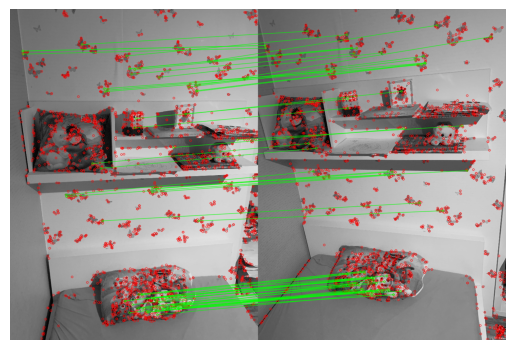

In [5]:
img1 = cv2.imread('source_images/im00.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('source_images/im01.png', cv2.IMREAD_GRAYSCALE)

sift = cv2.SIFT_create()

# Find the keypoints and descriptors with SIFT
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

# k-nearest neighbors matching
matches = flann.knnMatch(descriptors1, descriptors2, k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]
 
# Ratio test as per Lowe's paper https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf
for i,(m,n) in enumerate(matches):
    if m.distance < 0.4*n.distance:
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv2.DrawMatchesFlags_DEFAULT)
 
img3 = cv2.drawMatchesKnn(img1, keypoints1,img2,keypoints2,matches,None,**draw_params)

plt.imshow(img3)
plt.axis("off")
plt.show()

### Assignment 2

**Estimate the fundamental matrix using findFundamentalMat, compute the epipolar lines
for the feature points you used (you can use computeCorrespondEpilines) and draw these onto both
images**

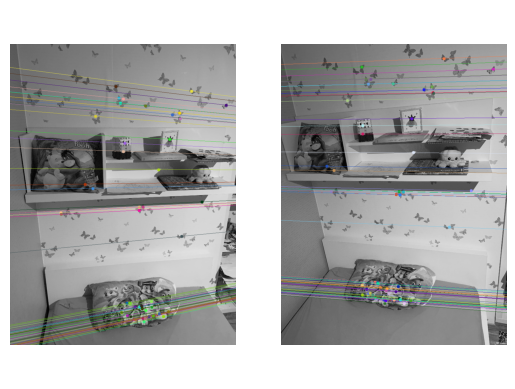

In [6]:
pts1 = []
pts2 = []
 
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.4*n.distance:
        pts2.append(keypoints2[m.trainIdx].pt)
        pts1.append(keypoints1[m.queryIdx].pt)
        
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on the left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
 
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
 
plt.axis("off")
plt.subplot(121),plt.imshow(img5)
plt.axis("off")
plt.subplot(122),plt.imshow(img3)
plt.axis("off")
plt.show()

## 2: The essential matrix

### Exercise 2:

**Compute the essential matrix, given that the camera used for both images has the following calibration
matrix:**

\begin{bmatrix}
792 & 0 & 505 \\
0 & 791 & 376 \\
0 & 0 & 1 \\
\end{bmatrix}

### Assignment 3

- **Compute the essential matrix from the fundamental matrix you estimated in Assignment 2, using
Equation 7 ($E = C′^T FC$) and the matrix above.**

In [7]:
# Given intrinsic camera matrix
C = np.array([
    [792, 0, 505],
    [0, 791, 376],
    [0, 0, 1]
])

# Compute the essential matrix E
E = C.T @ F @ C

In [8]:
print(E)

[[ 1.01948235e+00 -4.17193489e+01  2.73842328e-01]
 [-1.24552665e+02  3.34480847e+01  3.46183696e+02]
 [ 7.03008025e-01 -3.82633980e+02  2.67201198e+01]]


- **Compute the translation and rotation from the essential matrix using decomposeEssentialMat.
Print the rotation and translation matrices in your report**

In [9]:
R1, R2, t = cv2.decomposeEssentialMat(E)

print("Possible Rotation Matrix R1:\n", R1)
print("Possible Rotation Matrix R2:\n", R2)
print("Possible Translation t (up to scale):\n", t)

Possible Rotation Matrix R1:
 [[ 0.899571    0.02590945  0.43600542]
 [ 0.0093537   0.99686731 -0.07853711]
 [-0.4366744   0.07472797  0.89651057]]
Possible Rotation Matrix R2:
 [[ 0.97226713  0.02422083  0.23261552]
 [ 0.00482263 -0.99648765  0.0836009 ]
 [ 0.23382337 -0.08016058 -0.96896899]]
Possible Translation t (up to scale):
 [[ 0.99415102]
 [ 0.00752919]
 [-0.10773611]]


#### Question 1:

**You get two possible rotation matrices, which one do you think is correct? Hint: read Question
3 below.**

>The correct matrix is the following:

$$
\begin{pmatrix}
0.90182284 & 0.03058695 & 0.43102204 \\
0.00900537 & 0.99594451 & -0.08951783 \\
-0.43201212 & 0.08461074 & 0.89789006
\end{pmatrix}
$$

>If the rotation is assumed to be a pure rotation along the Y axis (vertical), then you should choose the rotation matrix that aligns with this assumption. In this case, based on the calculated angles in [question 3](#question-3), the above mentioned matrix seems more aligned with a rotation along the Y axis.

### Assignment 4

- **Convert the keypoint coordinates you used in Assignment 2 to normalized coordinates (for both images).**

In [10]:
# Normalize the coordinates
pts1_normalized = np.linalg.inv(C) @ np.vstack((pts1.T, np.ones(pts1.shape[0])))
pts2_normalized = np.linalg.inv(C) @ np.vstack((pts2.T, np.ones(pts2.shape[0])))

normalized_pts1 = pts1_normalized.T
normalized_pts2 = pts2_normalized.T

In [11]:
print("points_1 normalized:\n\n", normalized_pts1, "\n")
print("points_2 normalized:\n\n", normalized_pts2)

points_1 normalized:

 [[-0.4229798   0.23893805  1.        ]
 [-0.42171717  0.24525917  1.        ]
 [-0.32070707  0.11883692  1.        ]
 [-0.28787879  0.13653603  1.        ]
 [-0.27651515 -0.16940582  1.        ]
 [-0.19570707  0.64728192  1.        ]
 [-0.19570707  0.64728192  1.        ]
 [-0.19065657 -0.29582807  1.        ]
 [-0.1780303   0.69279393  1.        ]
 [-0.1780303  -0.24652339  1.        ]
 [-0.1780303  -0.24652339  1.        ]
 [-0.17171717 -0.22503161  1.        ]
 [-0.16666667  0.66118837  1.        ]
 [-0.15909091 -0.02022756  1.        ]
 [-0.15909091 -0.24273072  1.        ]
 [-0.15277778 -0.05562579  1.        ]
 [-0.1489899   0.67635904  1.        ]
 [-0.14393939  0.62199747  1.        ]
 [-0.14267677  0.67383059  1.        ]
 [-0.13257576  0.62073325  1.        ]
 [-0.13005051  0.62452592  1.        ]
 [-0.12752525  0.67888748  1.        ]
 [-0.11237374  0.69026549  1.        ]
 [-0.10984848  0.63843236  1.        ]
 [-0.10732323  0.69152971  1.        ]
 [

- **Compute the essential matrix by using findFundamentalMat on the normalized points.**

In [12]:
F_normalized, mask = cv2.findFundamentalMat(normalized_pts1, normalized_pts2, cv2.FM_LMEDS)

print("Fundamental Matrix F_normalized:\n", F_normalized)

Fundamental Matrix F_normalized:
 [[  0.04628929  -1.15077817  -0.02473753]
 [ -5.00803713   1.33667974  12.93865923]
 [  0.07346372 -14.29932071   1.        ]]


In [13]:
E = C.T @ F_normalized @ C

- **Compute the translation and rotation matrices once again with decomposeEssentialMat and print
them in your report. They should be close to results from Assignment 3, if not, you have a problem!**

In [14]:
R1_normalized, R2_normalized, t_normalized = cv2.decomposeEssentialMat(E)

print("Possible Rotation Matrix R1_normalized:\n", R1_normalized)
print("Possible Rotation Matrix R2_normalized:\n", R2_normalized)
print("Possible Translation t_normalized (up to scale):\n", t_normalized)

Possible Rotation Matrix R1_normalized:
 [[ 0.49409267 -0.34425931  0.79834702]
 [-0.34419213 -0.92069344 -0.18399828]
 [ 0.79837598 -0.18387256 -0.57339922]]
Possible Rotation Matrix R2_normalized:
 [[-0.99940931 -0.03432211 -0.00173991]
 [-0.02348813  0.64522871  0.76362833]
 [-0.0250867   0.76321812 -0.64565374]]
Possible Translation t_normalized (up to scale):
 [[ 0.50824494]
 [ 0.36981096]
 [-0.77777049]]


#### Question 2:

**The translation is only up to a scale factor. Does it correspond to your visual assessment of
the perspective difference between the shots? Explain.**

>Yes, the translation being up to a scale factor corresponds to the visual assessment of the perspective difference between the shots. In a calibrated camera setup, the translation vector is typically normalized, and its magnitude is not directly interpretable in terms of physical units. Instead, it captures the relative scale between translation and rotation. Therefore, the scale factor in the translation vector is not critical for understanding the perspective difference.

#### Question 3:

**Assuming that this rotation matrix would be a pure rotation along the Y axis (vertical), what
would be the approximate angle of the rotation?**

>

To find the approximate angle of rotation along the Y axis, you can examine the rotation matrix elements. For a rotation matrix representing a rotation around the Y axis, the non-zero elements would typically be in the first and third columns of the first row. In this case, looking at **Possible Rotation Matrix** the value at (1, 3) element is approximately -0.432. This value is related to the sine of the rotation angle. You can use the inverse sine function to find the approximate angle:

In [15]:
angle = math.degrees(math.asin(-0.432))
print("Approximate angle of rotation along Y axis:", angle)

Approximate angle of rotation along Y axis: -25.59455227837647


This will give you the approximate angle of the rotation along the Y axis.